In [1]:
import torch
import torchvision
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# XOR using Tensorflow


In [2]:
#Keras model



# XOR inputs and outputs
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([[0], [1], [1], [0]])

# Create a sequential model
model = Sequential()

# Add layers
model.add(Dense(4, input_dim=2, activation='relu'))
# model.add(Dense(2, input_dim=4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_history = model.fit(inputs, outputs, epochs=5000, verbose=0)

# Evaluate the model
print(model.evaluate(inputs, outputs))





1/1 [==============================] - 0s 284ms/step - loss: 0.0216 - accuracy: 1.0000
[0.021566059440374374, 1.0]


# Pytorch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Fashion MNIST

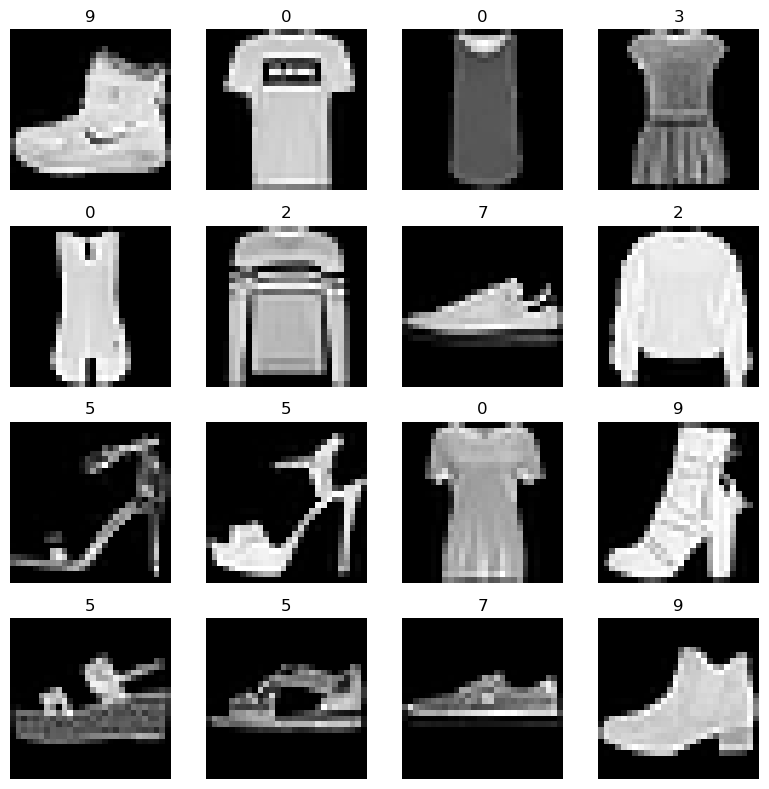

In [3]:
# loading dataset

transform = transforms.ToTensor()

train_dataset_FM = torchvision.datasets.FashionMNIST(root=r"E:\Projets\Datasets - Pytorch"  , train = True ,download= True , transform= transform)
test_data = torchvision.datasets.FashionMNIST(root=r"E:\Projets\Datasets - Pytorch"  , train = False ,download= True , transform= transform)

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):
    for j in range(4):
        image , label = train_dataset_FM[i * 4 + j]
        image_numpy = image.numpy(). squeeze()
        axs[i,j].imshow(image_numpy , cmap = 'gray')
        axs[i,j].axis('off')
        axs[i,j].set_title(label)

plt.tight_layout()
plt.show()

In [4]:


train_size = 56000
val_size = 4000

train_data , val_data = random_split(train_dataset_FM , [train_size , val_size])

# Print the sizes of the datasets
print(f'Train Dataset: {len(train_data)} samples')
print(f'Validation Dataset: {len(val_data)} samples')
print(f'Test Dataset: {len(test_data)} samples')

Train Dataset: 56000 samples
Validation Dataset: 4000 samples
Test Dataset: 10000 samples


In [5]:
# def extract_x_y(dataset):

#     x = []
#     y = []

#     for image , label in dataset:
#         x.append(image)
#         y.append(label)

#     return torch.stack(x) , torch.tensor(y)


# X_train , y_train = extract_x_y(train_data)
# X_test , y_test = extract_x_y(test_data)
# X_valid , y_valid = extract_x_y(val_data)

# print(f'X_train shape: {X_train.shape}, Y_train shape: {y_train.shape}')
# print(f'X_val shape: {X_valid.shape}, Y_val shape: {y_valid.shape}')
# print(f'X_test shape: {X_test.shape}, Y_test shape: {y_test.shape}')

In [6]:
train_loader = DataLoader(train_data, batch_size= 32 , shuffle=True)
test_loader = DataLoader(test_data, batch_size= 32 , shuffle=False)
val_loader = DataLoader(val_data, batch_size= 32 , shuffle=False)


In [12]:
class Fashion_Model(nn.Module):
    def __init__(self):
        super(Fashion_Model , self).__init__()
        self.flatten = nn.Flatten()
        self.Fc1 = nn.Linear(28 * 28 , 256)
        self.Fc2 = nn.Linear(256 , 128)
        self.Fc3 = nn.Linear(128 , 128)
        self.Bn1 = nn.BatchNorm1d(128)
        self.Fc4 = nn.Linear(128 , 64)
        self.Fc5 = nn.Linear(64 , 32)
        self.output = nn.Linear(32 , 10)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.Fc1(x))
        x = self.dropout(x)
        x = F.relu(self.Fc2(x))
        x = self.Bn1(x)
        x = F.relu(self.Fc3(x))
        x = self.dropout(x)
        x = F.relu(self.Fc4(x))
        x = F.relu(self.Fc5(x))
        x = self.output(x)

        return x
    
model = Fashion_Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=0.001)


In [13]:
print(torch.cuda.is_available())

True


In [14]:
#training

if torch.cuda.is_available():
    model = model.cuda()

train_losses= []
val_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for image , labels in train_loader:
        if torch.cuda.is_available():
            image , labels = image.cuda() , labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(image)

        loss = criterion(outputs , labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_train_loss = running_loss/len(train_loader)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for image , label in val_loader:
            if torch.cuda.is_available():
                image , label = image.cuda() , label.cuda()

            outputs = model(image)
            loss = criterion(outputs , label)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data , 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total * 100
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f'Epoch = {epoch} , TrainLoss = {avg_train_loss} ,  , Val Loss = {avg_val_loss} , Val Accuracy = {val_accuracy}' )



Epoch = 0 , TrainLoss = 0.6542101019706045 ,  , Val Loss = 0.45585970497131345 , Val Accuracy = 83.42500000000001
Epoch = 1 , TrainLoss = 0.47479185280629566 ,  , Val Loss = 0.39450355839729306 , Val Accuracy = 86.1
Epoch = 2 , TrainLoss = 0.4372618342723165 ,  , Val Loss = 0.38374469488859175 , Val Accuracy = 86.4
Epoch = 3 , TrainLoss = 0.4175528528690338 ,  , Val Loss = 0.36072186797857286 , Val Accuracy = 87.05000000000001
Epoch = 4 , TrainLoss = 0.39801838673438344 ,  , Val Loss = 0.3735564695000648 , Val Accuracy = 86.725
Epoch = 5 , TrainLoss = 0.3835566970578262 ,  , Val Loss = 0.3561453986167908 , Val Accuracy = 87.05000000000001
Epoch = 6 , TrainLoss = 0.3775623690400805 ,  , Val Loss = 0.3394241278767586 , Val Accuracy = 87.6
Epoch = 7 , TrainLoss = 0.3620584059187344 ,  , Val Loss = 0.3384426355957985 , Val Accuracy = 88.1
Epoch = 8 , TrainLoss = 0.36015514151964867 ,  , Val Loss = 0.3397443377971649 , Val Accuracy = 88.175
Epoch = 9 , TrainLoss = 0.3523554331511259 ,  , Va

In [15]:
with torch.no_grad():
    for image , label in test_loader:
        if torch.cuda.is_available():
            image , label = image.cuda() , label.cuda()

        outputs = model(image)
        loss = criterion(outputs , label)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data , 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    avg_loss = val_loss / len(test_loader)
    accuracy = correct / total * 100
print(f'accuracy =  {accuracy} , loss = {loss}')

accuracy =  88.5 , loss = 0.143647700548172


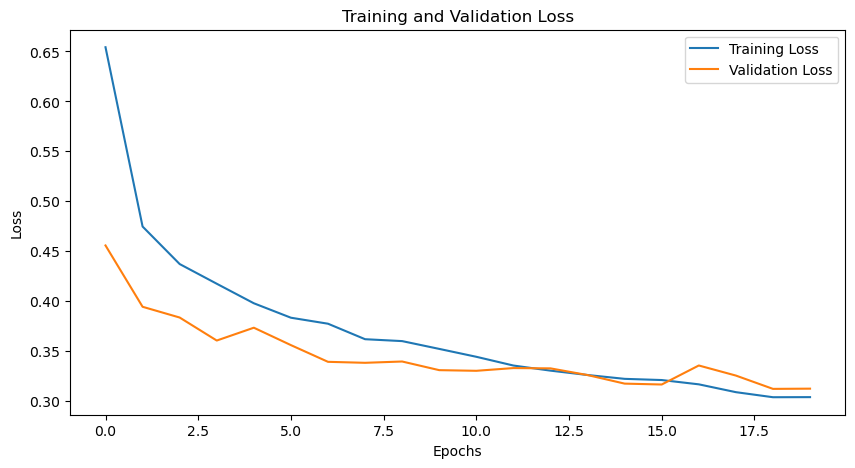

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

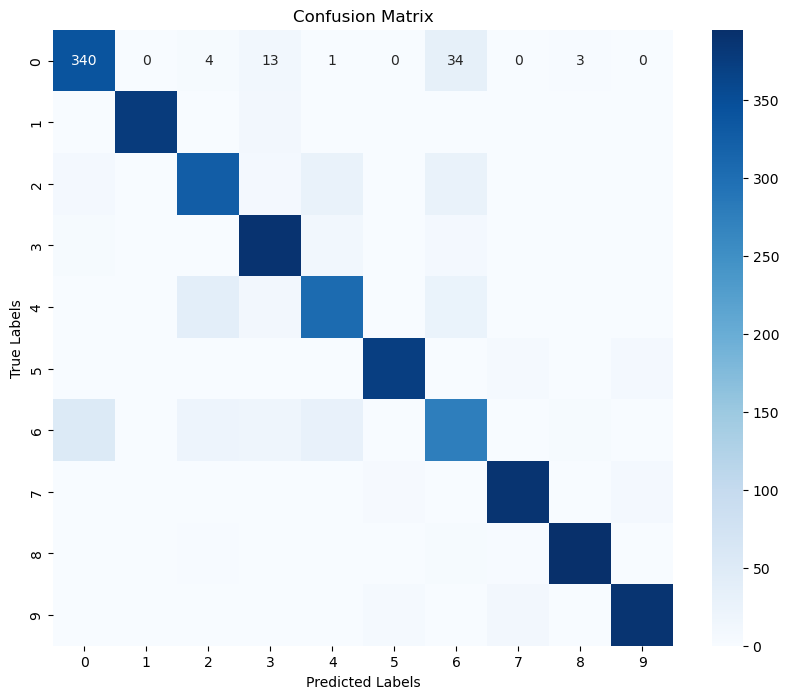

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Cifar10



In [2]:
transform = transforms.ToTensor()
cifar10_train = torchvision.datasets.CIFAR10(root=r"E:\Projets\Datasets - Pytorch" , train = True , download= True , transform=transform)
test_data = torchvision.datasets.CIFAR10(root=r"E:\Projets\Datasets - Pytorch" , train = False ,download= True ,  transform=transform)

Files already downloaded and verified
Files already downloaded and verified


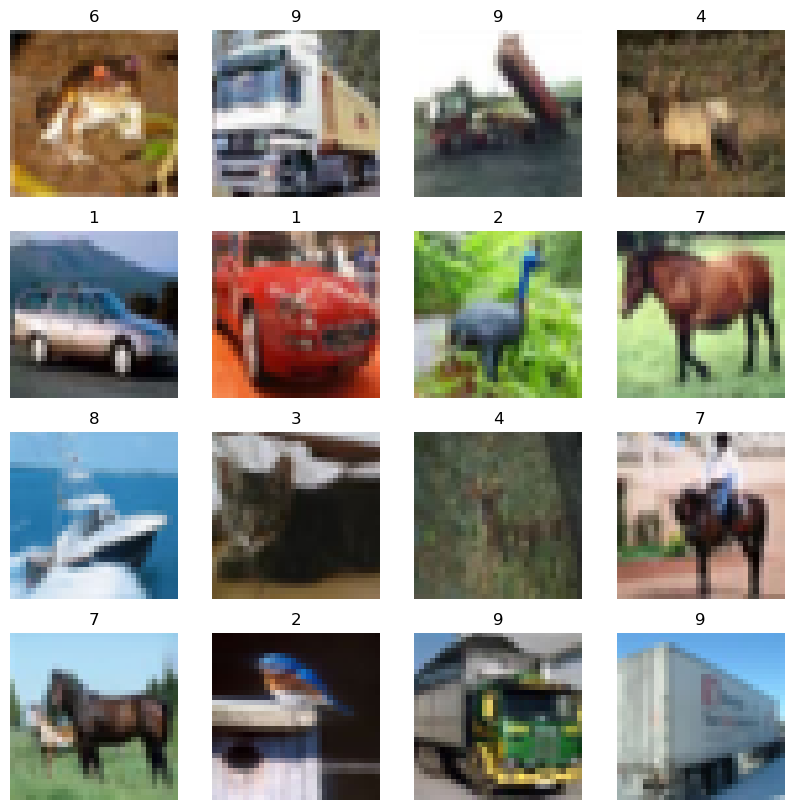

In [3]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        image, label = cifar10_train[i * 4 + j]
        
        # Transpose the image from (3, 32, 32) to (32, 32, 3)
        image_numpy = image.numpy().transpose((1, 2, 0))  # Reshape to HxWxC
        
        axs[i, j].imshow(image_numpy)
        axs[i, j].axis('off')
        axs[i, j].set_title(label)

plt.show()

In [4]:
len(cifar10_train)

50000

In [5]:
train_data, val_data = random_split(cifar10_train , [45008 , 4992])

print(f'Train Size: {len(train_data)}')
print(f'validation Size: {len(val_data)}')
print(f'Test Size: {len(test_data)}')


Train Size: 45008
validation Size: 4992
Test Size: 10000


In [6]:
train_loader = DataLoader(train_data , batch_size= 16)
val_loader = DataLoader(val_data , batch_size= 16)
test_loader = DataLoader(test_data , batch_size= 16)

In [7]:
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(512, 64)  

        self.fc2 = nn.Linear(64, 32)
        # self.fc3 = nn.Linear(128, 128)
        self.bn1 = nn.BatchNorm1d(32)
        # self.fc4 = nn.Linear()
        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # x = F.relu(self.conv4(x))
        # x = self.pool4(x)
        
        
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  # Flatten


        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.bn1(x)
        # x = self.dropout1(x)
        
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.output(x)

        return x

model = CifarModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=0.0001 ,weight_decay= 0.001)


In [17]:
if torch.cuda.is_available():
    model.cuda()

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

eps = 20
for epoch in range(eps):
    train_correct = 0
    train_total = 0
    running_loss = 0.0

    model.train()

    # Training loop
    for image, label in train_loader:
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()

        optimizer.zero_grad()
        outputs = model(image)

        loss = criterion(outputs, label)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    # Calculate average train loss and accuracy for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = (train_correct / train_total) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)

    # Validation loop
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, label in val_loader:
            if torch.cuda.is_available():
                images, label = images.cuda(), label.cuda()

            outputs = model(images)
            loss = criterion(outputs, label)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = (val_correct / val_total) * 100
    val_accuracies.append(val_accuracy)
    val_losses.append(avg_val_loss)

    print(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch: 0, Train Loss: 0.1903, Train Accuracy: 93.33%, Val Loss: 0.9948, Val Accuracy: 74.12%
Epoch: 1, Train Loss: 0.1828, Train Accuracy: 93.71%, Val Loss: 1.0840, Val Accuracy: 72.38%
Epoch: 2, Train Loss: 0.1785, Train Accuracy: 93.88%, Val Loss: 1.0251, Val Accuracy: 73.94%
Epoch: 3, Train Loss: 0.1749, Train Accuracy: 94.01%, Val Loss: 1.0104, Val Accuracy: 73.66%
Epoch: 4, Train Loss: 0.1708, Train Accuracy: 94.17%, Val Loss: 1.0333, Val Accuracy: 74.12%
Epoch: 5, Train Loss: 0.1673, Train Accuracy: 94.29%, Val Loss: 1.0191, Val Accuracy: 73.88%
Epoch: 6, Train Loss: 0.1593, Train Accuracy: 94.65%, Val Loss: 1.0354, Val Accuracy: 74.48%
Epoch: 7, Train Loss: 0.1661, Train Accuracy: 94.25%, Val Loss: 1.0508, Val Accuracy: 74.14%
Epoch: 8, Train Loss: 0.1629, Train Accuracy: 94.39%, Val Loss: 1.0449, Val Accuracy: 73.94%
Epoch: 9, Train Loss: 0.1594, Train Accuracy: 94.59%, Val Loss: 1.0552, Val Accuracy: 73.26%
Epoch: 10, Train Loss: 0.1563, Train Accuracy: 94.59%, Val Loss: 1.075

In [18]:
test_correct = 0
test_total = 0
test_loss = 0.0

model.eval()
with torch.no_grad():
    for image, label in test_loader:
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()

        outputs = model(image)

        loss = criterion(outputs, label)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()

    # Calculate average loss and accuracy outside the loop
    avg_loss = test_loss / len(test_loader)
    test_accuracy = (test_correct / test_total) * 100

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.0157, Test Accuracy: 74.65%


In [19]:
print(len(train_accuracies))

20


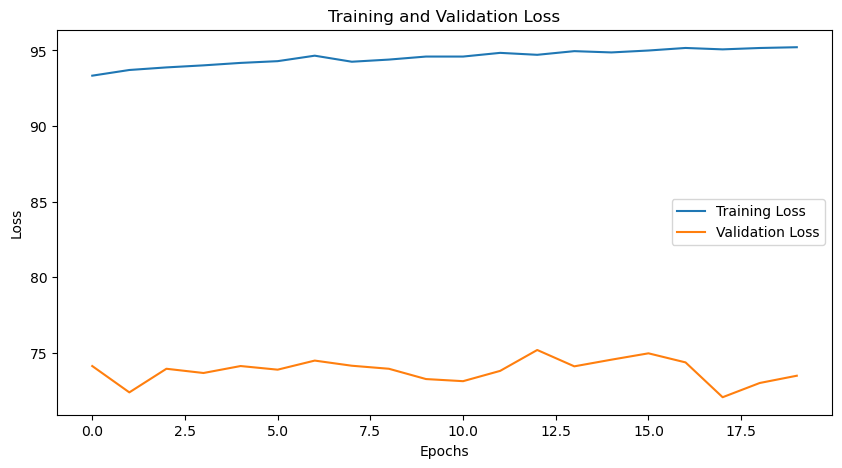

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()